<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/notebooks/Vinod_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.formula.api as smf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
!pip install qnorm
import qnorm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 363 kB 2.1 MB/s 


In [16]:
expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

In [6]:
ACC = "A.C. cortex"
CER = "cerebellum"
DLPFC = "D.L.P.F. cortex"


## EDA

In [ ]:
for lab in samples.lab.unique():
  

# Compute Bacterial Genes

In [9]:
# Need to compute all bacteria genes. Contains AFFX, does Not have HUM
genes.at["AFFX-BioDn-3_at", 'chrom'] = float("Nan")
genes_control = genes[['AFFX' in s for s in genes.index]]
genes_control = genes_control[['HUM' not in s for s in genes_control.index]]
genes_control = genes_control[['hum' not in s for s in genes_control.index]]
genes_bac_index = genes_control[genes_control.chrom.isnull() & genes_control.sym.isnull()].index
print(genes_bac_index)


Index(['AFFX-BioB-3_at', 'AFFX-BioB-3_st', 'AFFX-BioB-5_at', 'AFFX-BioB-5_st',
       'AFFX-BioB-M_at', 'AFFX-BioB-M_st', 'AFFX-BioC-3_at', 'AFFX-BioC-3_st',
       'AFFX-BioC-5_at', 'AFFX-BioC-5_st', 'AFFX-BioDn-3_at',
       'AFFX-BioDn-3_st', 'AFFX-BioDn-5_at', 'AFFX-BioDn-5_st',
       'AFFX-CreX-3_at', 'AFFX-CreX-3_st', 'AFFX-CreX-5_at', 'AFFX-CreX-5_st',
       'AFFX-DapX-3_at', 'AFFX-DapX-5_at', 'AFFX-DapX-M_at', 'AFFX-LysX-3_at',
       'AFFX-LysX-5_at', 'AFFX-LysX-M_at', 'AFFX-M27830_3_at',
       'AFFX-M27830_5_at', 'AFFX-M27830_M_at', 'AFFX-MurFAS_at',
       'AFFX-MurIL10_at', 'AFFX-MurIL2_at', 'AFFX-MurIL4_at', 'AFFX-PheX-3_at',
       'AFFX-PheX-5_at', 'AFFX-PheX-M_at', 'AFFX-ThrX-3_at', 'AFFX-ThrX-5_at',
       'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at', 'AFFX-TrpnX-5_at',
       'AFFX-TrpnX-M_at', 'AFFX-YEL002c/WBP1_at', 'AFFX-YEL018w/_at',
       'AFFX-YEL021w/URA3_at', 'AFFX-YEL024w/RIP1_at'],
      dtype='object', name='rownames')


# Genes to Probe Set

In [10]:
genes_sym = genes[genes.sym.notnull()]
unique_genes = genes_sym["sym"].unique()
gene_to_probe_set = {}

for gene in unique_genes:
  gene_to_probe_set[gene] = genes_sym.index[genes_sym.sym == gene].tolist()

# Normalize Data

In [39]:
genes_Y_crom = genes[genes.chrom == "Y"].index
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)
expression_qnorm = qnorm.quantile_normalize(expression, axis=0)
expression_ecdf = expression.copy()
for i in range(len(expression)):
  ecdf = ECDF(expression_ecdf.iloc[i, :].values)
  expression_ecdf.iloc[i, :] = ecdf(expression_ecdf.iloc[i, :].values)

# Hypothesis Testing

In [65]:
def compute_top_genes_tissue(data, tissue):
  sig_genes = 0
  express_norm_samp = pd.concat([data, samples], axis=1)
  express_samp_loc = express_norm_samp

  df_male = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "male")]
  df_female = express_samp_loc[(express_samp_loc.region == tissue) & (express_samp_loc.sex == "female")]

  unique_probe_set = data.columns
  probe_set_to_pvalue = {}

  for probe_set in unique_probe_set:
    stat, p = stats.ks_2samp(data.loc[df_male.index][probe_set], data.loc[df_female.index][probe_set])
    probe_set_to_pvalue[probe_set] = (p, stat)

  gene_p_values = []

  for gene in genes_sym["sym"].unique():
    gene_p = 0
    gene_stat = 0
    gene_probes = gene_to_probe_set[gene]
    for probe in gene_probes:
      if gene_p < probe_set_to_pvalue[probe][0]:
        gene_stat = probe_set_to_pvalue[probe][1]
      gene_p = max(gene_p, probe_set_to_pvalue[probe][0])
    if gene_p < 0.01:
      sig_genes += 1
    gene_p_values.append((gene_p, gene, gene_stat))
    
  sorted_pval = sorted(gene_p_values, key=lambda tup: tup[0])
  p_values = [tup[0] for tup in sorted_pval]
  stat_values = [tup[2] for tup in sorted_pval]
  topgenes = [tup[1] for tup in sorted_pval[:10]]
  topchrom = [genes[genes.sym == tg]["chrom"][0] for tg in topgenes]
  chrom_counter = Counter(topchrom)
  count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
  return topgenes, topchrom, count, p_values, stat_values

In [ ]:
topgenes, topchrom, cnt, p_values, stat_value_ACC = compute_top_genes_tissue(expression_norm, ACC)
print(topgenes, topchrom, p_values[:10])
topgenes, topchrom, cnt, p_values, stat_value_CER = compute_top_genes_tissue(expression_norm, CER)
print(topgenes, topchrom, p_values[:10])
topgenes, topchrom, cnt, p_values, stat_value_DLPFC = compute_top_genes_tissue(expression_norm, DLPFC)
print(topgenes, topchrom, p_values[:10])


(array([1.535e+03, 3.955e+03, 2.178e+03, 1.057e+03, 4.700e+01, 3.000e+00,
        4.000e+00, 0.000e+00, 2.000e+00, 2.000e+00]),
 array([0.07142857, 0.16428571, 0.25714286, 0.35      , 0.44285714,
        0.53571429, 0.62857143, 0.72142857, 0.81428571, 0.90714286,
        1.        ]),
 <a list of 10 Patch objects>)

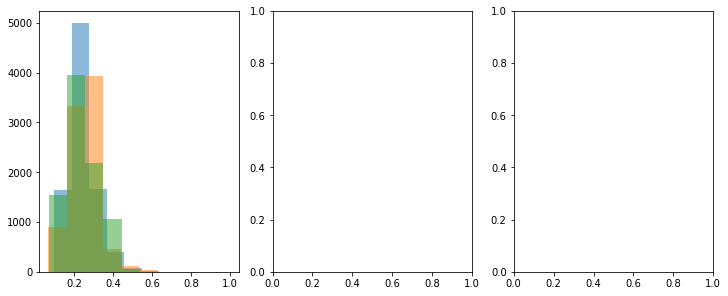

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
colors = ["blue", "red", "green"]
axs[0].hist(stat_value_ACC, alpha= 0.50, bins=10)
axs[0].hist(stat_value_CER, alpha= 0.50, bins=10)
axs[0].hist(stat_value_DLPFC, alpha= 0.50, bins=10)

In [66]:
topgenes, topchrom, cnt = compute_top_genes_tissue(expression_norm, CER)
print(topgenes)
print(topchrom)
print(cnt)

['DDX3Y', 'RPS4Y1', 'KDM5D', 'XIST', 'UTY', 'CD24', 'TTTY15', 'USP9Y', 'DUSP5', 'GEMIN4']
['Y', 'Y', 'Y', 'X', 'Y', '6', 'Y', 'Y', '10', '17']
7


In [67]:
topgenes, topchrom, cnt = compute_top_genes_tissue(expression_norm, DLPFC)
print(topgenes)
print(topchrom)
print(cnt)

['DDX3Y', 'RPS4Y1', 'USP9Y', 'XIST', 'UTY', 'KDM5D', 'HNRNPF', 'TTTY15', 'NLGN4Y', 'HIST1H3I']
['Y', 'Y', 'Y', 'X', 'Y', 'Y', '10', 'Y', 'Y', '6']
8


#OLS

Is there heteroscadiscity across labs even after normalization? How much did noramlization help us?*italicized text*

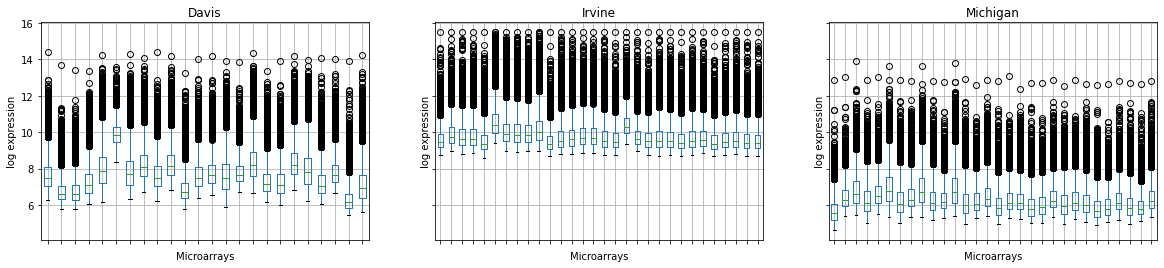

In [36]:
#grab the data for one person
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharey = "all")
c = 0
for lab in samples["lab"].unique():
  lab_index = samples[samples.lab == lab].index
  expressions_lab = expression.loc[lab_index]
  expressions_lab.T.boxplot(ax = axs[c])
  axs[c].set_xlabel("Microarrays")
  axs[c].set_ylabel("log expression")
  axs[c].title.set_text(lab)
  axs[c].set(xticklabels=[])
  c += 1


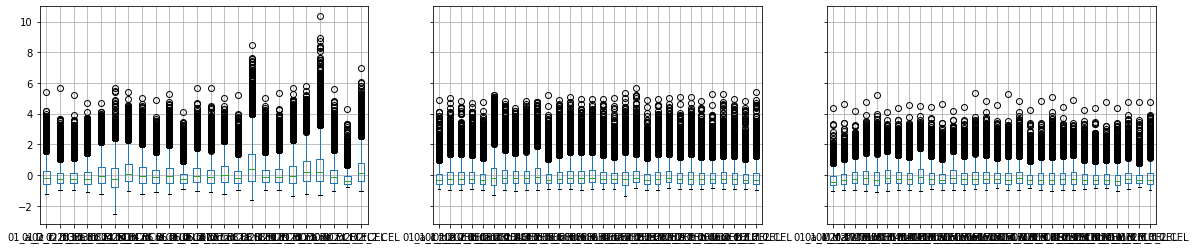

In [24]:
#grab the data for one person
fig, axs = plt.subplots(1, 3, figsize=(20, 4), sharey = "all")
c = 0
for lab in samples["lab"].unique():
  lab_index = samples[samples.lab == lab].index
  expressions_lab = expression_norm.loc[lab_index]
  expressions_lab.T.boxplot(ax = axs[c])
  c += 1


In [25]:
human_probes = genes[['AFFX' not in s for s in genes.index]].index
unique_probe_set = human_probes
num_sig = 0
alpha = 0.01
for probe in unique_probe_set[:]:
  samples_tmp = samples.drop(columns= ["patient"]);
  one_hot_encoding = pd.get_dummies(samples_tmp);
  one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "region_cerebellum", "lab_Davis"]);
  X = sm.add_constant(one_hot_encoding);
  model = sm.OLS(expression[probe],X).fit();
  hetero_test = het_white(model.resid,  model.model.exog)

  #define labels to use for output of White's test
  labels = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']

  #print results of White's test
  p = dict(zip(labels, hetero_test))["p-value"]
  if p <= alpha:
    num_sig += 1
print(num_sig)




12181


In [26]:
human_probes = genes[['AFFX' not in s for s in genes.index]].index
unique_probe_set = human_probes
num_sig = 0
alpha = 0.01
for probe in unique_probe_set[:]:
  samples_tmp = samples.drop(columns= ["patient"]);
  one_hot_encoding = pd.get_dummies(samples_tmp);
  one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "region_cerebellum", "lab_Davis"]);
  X = sm.add_constant(one_hot_encoding);
  model = sm.OLS(expression_norm[probe],X).fit();
  hetero_test = het_white(model.resid,  model.model.exog)
  # plt.scatter(expression[probe], model.resid)

  #define labels to use for output of White's test
  labels = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']

  #print results of White's test
  p = dict(zip(labels, hetero_test))["p-value"]
  if p <= alpha:
    num_sig += 1
print(num_sig)




3634


In [27]:
human_probes = genes[['AFFX' not in s for s in genes.index]].index
unique_probe_set = human_probes
num_sig = 0
alpha = 0.01
for probe in unique_probe_set[:]:
  samples_tmp = samples.drop(columns= ["patient"]);
  one_hot_encoding = pd.get_dummies(samples_tmp);
  one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "region_cerebellum", "lab_Davis"]);
  X = sm.add_constant(one_hot_encoding);
  model = sm.OLS(expression_qnorm[probe],X).fit();
  hetero_test = het_white(model.resid,  model.model.exog)
  # plt.scatter(expression[probe], model.resid)

  #define labels to use for output of White's test
  labels = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']

  #print results of White's test
  p = dict(zip(labels, hetero_test))["p-value"]
  if p <= alpha:
    num_sig += 1
print(num_sig)




4601


Compared to un-normalized data, with normalized data, we observe that the number of columns with significant hetero are reduced. How does the hetero change if we run regression models on individual labs? 

In [29]:
human_probes = genes[['AFFX' not in s for s in genes.index]].index
unique_probe_set = human_probes
for lab in samples.lab.unique():
  print(lab)
  num_sig = 0
  alpha = 0.01
  probe_set_to_pvalue = {}
  for probe_set in unique_probe_set:
    lab_index = samples[samples.lab == lab].index;
    samples_tmp = samples.drop(columns= ["patient", "lab"]);
    one_hot_encoding = pd.get_dummies(samples_tmp);
    one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "region_cerebellum"]);
    X = sm.add_constant(one_hot_encoding);
    model = sm.OLS(expression_norm.loc[lab_index][probe_set],X.loc[lab_index]).fit();
    hetero_test = het_white(model.resid,  model.model.exog)

    labels = ['Lagrange multiplier statistic', 'p-value',
          'f-value', 'f p-value']

    #print results of White's test
    p = dict(zip(labels, hetero_test))["p-value"]
    if p <= alpha:
      num_sig += 1
  print(num_sig)
  print("")




Davis
322

Irvine
344

Michigan
322



In [30]:
human_probes = genes[['AFFX' not in s for s in genes.index]].index
unique_probe_set = human_probes
for lab in samples.lab.unique():
  print(lab)
  num_sig = 0
  alpha = 0.01
  probe_set_to_pvalue = {}
  for probe_set in unique_probe_set:
    lab_index = samples[samples.lab == lab].index;
    samples_tmp = samples.drop(columns= ["patient", "lab"]);
    one_hot_encoding = pd.get_dummies(samples_tmp);
    one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "region_cerebellum"]);
    X = sm.add_constant(one_hot_encoding);
    model = sm.OLS(expression_qnorm.loc[lab_index][probe_set],X.loc[lab_index]).fit();
    hetero_test = het_white(model.resid,  model.model.exog)

    labels = ['Lagrange multiplier statistic', 'p-value',
          'f-value', 'f p-value']

    #print results of White's test
    p = dict(zip(labels, hetero_test))["p-value"]
    if p <= alpha:
      num_sig += 1
  print(num_sig)
  print("")




Davis
1494

Irvine
97

Michigan
223



Davis
0

Irvine
0

Michigan
0



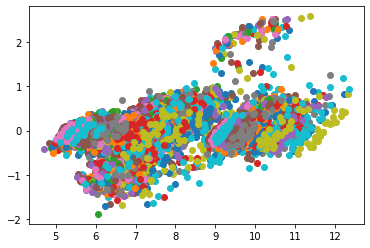

In [34]:
human_probes = genes[['AFFX' not in s for s in genes.index]].index
unique_probe_set = human_probes
for lab in samples.lab.unique():
  print(lab)
  num_sig = 0
  alpha = 0.01
  probe_set_to_pvalue = {}
  for probe_set in unique_probe_set[:100]:
    lab_index = samples[samples.lab == lab].index;
    samples_tmp = samples.drop(columns= ["patient", "lab"]);
    one_hot_encoding = pd.get_dummies(samples_tmp);
    one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "region_cerebellum"]);
    X = sm.add_constant(one_hot_encoding);
    model = sm.OLS(expression.loc[lab_index][probe_set],X.loc[lab_index]).fit();
    hetero_test = het_white(model.resid,  model.model.exog)
    plt.scatter(expression.loc[lab_index][probe_set], model.resid)

    labels = ['Lagrange multiplier statistic', 'p-value',
          'f-value', 'f p-value']

    #print results of White's test
    p = dict(zip(labels, hetero_test))["p-value"]
    if p <= alpha:
      num_sig += 1
  print(num_sig)
  print("")




We observe that analyzing each lab seperately, significantly reduces the number of total heteroscadistic columns. 

## OLS per lab

lab by lab

In [33]:
unique_probe_set = expression_norm.columns
for lab in samples.lab.unique():
  print(lab)
  probe_set_to_pvalue = {}
  for probe_set in unique_probe_set:
    lab_index = samples[samples.lab == lab].index;
    samples_tmp = samples.drop(columns= ["patient", "lab"]);
    one_hot_encoding = pd.get_dummies(samples_tmp);
    one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "region_cerebellum"]);
    X = sm.add_constant(one_hot_encoding);
    model = sm.OLS(expression.loc[lab_index][probe_set],X.loc[lab_index]).fit();
    p_value = model.pvalues["sex_male"];
    probe_set_to_pvalue[probe_set] = p_value

  gene_p_values = []
  for gene in genes_sym["sym"].unique():
    gene_p = 0
    gene_probes = gene_to_probe_set[gene]
    for probe in gene_probes:
      gene_p = max(gene_p, probe_set_to_pvalue[probe])
    gene_p_values.append((gene_p, gene))

  sorted_pval = sorted(gene_p_values, key=lambda tup: tup[0])
  topgenes = [tup[1] for tup in sorted_pval[:10]]
  topchrom = [genes[genes.sym == tg]["chrom"][0] for tg in topgenes]
  chrom_counter = Counter(topchrom)
  count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
  print(topgenes)
  print(topchrom)
  print(count)
  print("")




Davis
['RPS4Y1', 'DDX3Y', 'HBB', 'XIST', 'IFITM1', 'USP9Y', 'TF', 'CRYAB', 'GAD1', 'CTGF']
['Y', 'Y', '11', 'X', '11', 'Y', '3', '11', '2', '6']
4

Irvine
['RPS4Y1', 'DDX3Y', 'KDM5D', 'USP9Y', 'UTY', 'XIST', 'CYorf15B', 'GABRA6', 'NCL', 'EIF1AY']
['Y', 'Y', 'Y', 'Y', 'Y', 'X', 'Y', '5', '2', 'Y']
8

Michigan
['RPS4Y1', 'DDX3Y', 'KDM5D', 'TTTY15', 'CD24', 'USP9Y', 'CYorf15B', 'UTY', 'CD99', 'STXBP3']
['Y', 'Y', 'Y', 'Y', '6', 'Y', 'Y', 'Y', 'X Y', '1']
8



In [14]:
unique_probe_set = expression_norm.columns
probe_set_to_pvalue = {}
for probe_set in unique_probe_set:
  samples_tmp = samples.drop(columns= ["patient"]);
  one_hot_encoding = pd.get_dummies(samples_tmp);
  one_hot_encoding = one_hot_encoding.drop(columns= ["sex_female", 'chip.version_v2', "region_cerebellum", "lab_Davis"]);
  X = sm.add_constant(one_hot_encoding);
  model = sm.OLS(expression_norm[probe_set],X).fit();
  p_value = model.pvalues["sex_male"];
  probe_set_to_pvalue[probe_set] = p_value

gene_p_values = []
for gene in genes_sym["sym"].unique():
  gene_p = 0
  gene_probes = gene_to_probe_set[gene]
  for probe in gene_probes:
    gene_p = max(gene_p, probe_set_to_pvalue[probe])
  gene_p_values.append((gene_p, gene))

sorted_pval = sorted(gene_p_values, key=lambda tup: tup[0])
topgenes = [tup[1] for tup in sorted_pval[:10]]
topchrom = [genes[genes.sym == tg]["chrom"][0] for tg in topgenes]
chrom_counter = Counter(topchrom)
count = np.sum([chrom_counter[key] for key, value in chrom_counter.items() if key in ["X", "Y", "X Y"]])
print(topgenes)
print(topchrom)
print(count)
  # print(model.pvalues["sex_male"])
print("")




['RPS4Y1', 'KDM5D', 'HMGB2', 'DDX3Y', 'SPON1', 'HBB', 'HIST1H2AC', 'CHGB', 'HIST1H1C', 'EFEMP1']
['Y', 'Y', '4', 'Y', '11', '11', '6', '20', '6', '2']
3

